## Import the important libraries 

In [1]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
import collections
from scipy.stats import entropy

## Create functions that will be used 

In [48]:
def estimate_shannon_entropy(columnCount):
    # define distribution
    dist = [x/sum(columnCount) for x in columnCount]
    # use scipy to calculate entropy
    entropy_value = entropy(dist, base=2)
 
    return entropy_value

def CreateTxt(lines, name, tofile = False):
    txt = ''
    for line in lines:
        txt += ' -1 '.join(map(str,line)) + ' -2\n'
    if tofile:
        text_file = open(name, "w")
        text_file.write(txt)
        text_file.close()
    else: 
        return txt
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

['104,201,10',
 '103,201,10',
 '101,201,10',
 '105,201,10',
 '109,201,10',
 '108,201,10',
 '201,000400,10',
 '110,201,10',
 '107,201,10',
 '102,201,10',
 '106,201,10',
 '201,003400,10',
 '201,020000,10',
 '201,100000,10',
 '201,10,10',
 '102,10,10',
 '105,000400,10',
 '020000,000400,10',
 '000400,000400,10',
 '10,000400,10',
 '202,10,10',
 '105,10,10',
 '000400,10,10',
 '102,201,10,10',
 '101,10,10',
 '105,201,10,10',
 '101,201,10,10',
 '10,023000,10',
 '103,10,10',
 '10,020000,10']

## Read data and look at it

In [3]:
df = pd.read_csv('InitialCSVS/discoverCal_sequence_wEndSignal_v3.csv', header=0)

In [4]:
df.head()

ids  Unnamed: 1  Unnamed: 2  Unnamed: 3  \
0  pid5c1546d2c6022b43038782c767bf20d8           1           1          10   
1  pid5c1546d2c6022b43038782c767bf20d8           2           1          10   
2  pid5c1546d2c6022b43038782c767bf20d8           3           1          10   
3  pid5c1546d2c6022b43038782c767bf20d8           4           1          10   
4  pid5c1546d2c6022b43038782c767bf20d8           5           1          10   

   Unnamed: 4  Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  \
0          10        10.0        30.0       666.0         NaN         NaN   
1          10     20000.0      3000.0        10.0       666.0         NaN   
2      100000        10.0     20000.0        10.0       666.0         NaN   
3          10        10.0        10.0        10.0       666.0         NaN   
4          10        10.0        10.0        10.0      3400.0    100000.0   

   ...  Unnamed: 16  Unnamed: 17  Unnamed: 18  Unnamed: 19  Unnamed: 20  \
0  ...          NaN          NaN          NaN          NaN          NaN   
1  ...          NaN          NaN          NaN          NaN          NaN   
2  ...          NaN          NaN          NaN          NaN          NaN   
3  ...          NaN          NaN          NaN          NaN          NaN   
4  ...        400.0         10.0         10.0         10.0        666.0   

   Unnamed: 21  Unnamed: 22  Unnamed: 23  Unnamed: 24  last  
0          NaN          NaN          NaN          NaN   NaN  
1          NaN          NaN          NaN          NaN   NaN  
2          NaN          NaN          NaN          NaN   NaN  
3          NaN          NaN          NaN          NaN   NaN  
4          NaN          NaN          NaN          NaN   NaN  

[5 rows x 26 columns]

## Start editing the data. (ETL)
Since python looks at the data and thinks it should be numerical it deletes the initial ceros that do have meaning in this context, so I make sure that everything is right and modify the data.

In [5]:
onlyTask = False
lines = []
for line in df.iterrows():
    counter = 0
    newline = []
    for i in line[1][1:]:
        if math.isnan(i):
            break
        i = int(i)
        counter += 1
        if counter == 1:
            i = i + 100
        elif (onlyTask) and (counter ==2):
            continue
        elif counter == 2:
            i = i+200
        elif (i != 10) and (i != 20) and (i != 30) and (i != 100000) and (i != 666) and (counter != 2):
            if str(i)[0] == '2':
                i = '0' + str(int(i))
            elif str(i)[0] == '3':
                i = '00' + str(int(i))
            elif str(i)[0] == '4':
                i = '000' + str(int(i))
            elif str(i)[0] == '5':
                i = '0000' + str(int(i))
            elif str(i)[0] == '6':
                i = '00000' + str(int(i))
        newline.append(i)
    lines.append(newline)


Then safe tha data into the files

In [8]:
if onlyTask:
    CreateTxt(lines, 'InitialCSVS/OnlyTask.txt')
else:
    CreateTxt(lines, 'SPMFResutls/withEnd.txt', True)

And read the results from spmf so we are sure we can compare everything. I will also be editing so it is comparable to the other data (and as it can be seen spmf things 003400 is numerical, so it becomes 3400, so this needs to be handled as well.

In [6]:
content = pd.read_csv('SPMFResutls/EndResults.csv', header=0)

In [7]:
content

Pattern  #SUP:  \
0           3400 -1 10 -1 10 -1   44.0   
1          201 -1 3400 -1 10 -1   43.0   
2             201 -1 10 -1 6 -1   67.0   
3          201 -1 10 -1 3400 -1   49.0   
4    201 -1 10 -1 3400 -1 10 -1   41.0   
..                          ...    ...   
101         109 -1 201 -1 10 -1   38.0   
102          109 -1 10 -1 10 -1   44.0   
103    109 -1 10 -1 10 -1 10 -1   36.0   
104         110 -1 201 -1 10 -1   34.0   
105          110 -1 10 -1 10 -1   38.0   

                                                 #SID:  
0    4 23 31 43 77 109 121 164 172 176 207 266 277 ...  
1    4 23 31 43 61 65 109 157 161 172 176 181 185 1...  
2    9 34 37 41 62 66 69 74 76 78 91 93 113 120 136...  
3    4 23 31 43 61 93 109 157 161 164 172 176 181 1...  
4    4 23 31 43 61 109 157 161 164 172 176 181 185 ...  
..                                                 ...  
101  8 20 47 58 71 99 116 127 153 168 189 203 225 2...  
102  8 20 47 58 71 99 116 127 153 155 168 189 203 2...  
103  8 20 47 58 71 99 116 127 155 168 189 203 225 2...  
104  9 21 48 59 72 85 100 117 128 156 190 204 242 2...  
105  9 21 48 59 72 85 100 117 128 156 190 204 207 2...  

[106 rows x 3 columns]

In [11]:
support = []
ids = []
itemsets = []
for col in content.iterrows(): 
    col = col[1]
    new = col[0].split(' -1')
    new = [x.strip(' ') for x in new]
    support.append(int(col[1]))
    ids.append(col[2].split(' '))
    itemsets.append(new[:-1])
sortedItems = [x for _,x in sorted(zip(support,itemstets), reverse=True)]
sortedids = [x for _,x in sorted(zip(support,ids), reverse=True)]

In [13]:
len(itemsets)

106

In [14]:
sortedItems = sortedItems[:30]
sortedItems = itemsets

In [15]:
for j in range(len(sortedItems)):
    newline = []
    for i in sortedItems[j]:
        i = int(i)
        if i > 99 and i < 220:
            n = 2
        elif (i != 10) and (i != 20) and (i != 30) and (i != 100000):
            if str(i)[0] == '2':
                i = '0' + str(int(i))
            elif str(i)[0] == '3':
                i = '00' + str(int(i))
            elif str(i)[0] == '4':
                i = '000' + str(int(i))
            elif str(i)[0] == '5':
                i = '0000' + str(int(i))
            elif str(i)[0] == '6':
                i = '00000' + str(int(i))
        newline.append(i)
    sortedItems[j]=newline

In [17]:
len(sortedItems)

106

### Correlation matrix
Now that we have the first 30 most important items, then we can create the correlation matrix between them, just that first we need to the dataframe and see which silst contain these frequent itemsets.

In [18]:
row_names = []
for i in range(len(sortedItems)):
    sortedItems[i]=list(map(str,sortedItems[i]))
    row_names.append(",".join(sortedItems[i]))

In [19]:
col_names = []
for i in range(len(lines)):
    lines[i]=list(map(str,lines[i]))
    col_names.append(",".join(lines[i]))

In [20]:
df_final = pd.DataFrame.from_records([[0]*len(col_names)]*len(sortedItems),columns = col_names, nrows=30)
df_final.index = row_names

In [21]:
for i in range(len(sortedItems)):
    checkItem = sortedItems[i]
    for j in range(len(lines)):
        line = lines[j]
        bigLen = len(line)
        shortLen = len(checkItem)
        if shortLen <= bigLen:
            counter = 0
            for elem in line:
                for k in range(shortLen):
                    if(k < counter):
                        continue
                    item = checkItem[k]
                    if (item == elem):
                        counter += 1
                        break
            if counter == shortLen:
                df_final.iloc[i,j] = 1

In [56]:
df_final.head()

101,201,10,10,10,30,666  102,201,10,10,020000,003000,10,666  \
003400,10,10                            1                                   1   
201,003400,10                           1                                   1   
201,10,000006                           0                                   0   
201,10,003400                           0                                   0   
201,10,003400,10                        1                                   1   

                  103,201,10,100000,10,020000,10,666  \
003400,10,10                                       1   
201,003400,10                                      1   
201,10,000006                                      0   
201,10,003400                                      0   
201,10,003400,10                                   1   

                  104,201,10,10,10,10,10,666  \
003400,10,10                               1   
201,003400,10                              1   
201,10,000006                              0   
201,10,003400                              0   
201,10,003400,10                           1   

                  105,201,10,10,10,10,10,003400,100000,10,000400,023000,020000,003400,10,000400,10,10,10,666  \
003400,10,10                                                      1                                            
201,003400,10                                                     1                                            
201,10,000006                                                     0                                            
201,10,003400                                                     1                                            
201,10,003400,10                                                  1                                            

                  106,201,10,10,666  107,201,10,10,000400,10,100000,10,666  \
003400,10,10                      0                                      1   
201,003400,10                     1                                      1   
201,10,000006                     0                                      0   
201,10,003400                     0                                      0   
201,10,003400,10                  0                                      1   

                  108,201,10,30,10,10,666  \
003400,10,10                            1   
201,003400,10                           1   
201,10,000006                           0   
201,10,003400                           0   
201,10,003400,10                        1   

                  109,201,10,100000,020000,10,10,000400,10,10,000400,10,10,10,666  \
003400,10,10                                                      1                 
201,003400,10                                                     1                 
201,10,000006                                                     0                 
201,10,003400                                                     0                 
201,10,003400,10                                                  1                 

                  110,201,10,10,000006,666  ...  \
003400,10,10                             0  ...   
201,003400,10                            1  ...   
201,10,000006                            1  ...   
201,10,003400                            0  ...   
201,10,003400,10                         0  ...   

                  102,202,000400,020000,000400,10,000050,666  \
003400,10,10                                               0   
201,003400,10                                              0   
201,10,000006                                              0   
201,10,003400                                              0   
201,10,003400,10                                           0   

                  102,203,003006,666  \
003400,10,10                       0   
201,003400,10                      0   
201,10,000006                      0   
201,10,003400                      0   
201,10,003400,10                   0   

                  102,204,100000,10,100000,00040

In [62]:
df_shanon = df_final.copy()
df_shanon = df_shanon.T
df_shanon['IDS'] = list(df.ids)
df_shanon = df_shanon.groupby(['IDS']).sum()
lf = df_shanon.apply(estimate_shannon_entropy,0)
final_rows = list(lf.sort_values(ascending=False).index)[:30]



In [65]:
df_final = df_final.loc[final_rows,:]

In [66]:
data = []
for first in df_final.iterrows():
    row = []
    for line in df_final.iterrows():
        row.append(distance.jaccard(list(first[1]),list(line[1])))
    data.append(row)


In [67]:
corr_matrix = pd.DataFrame.from_records(data, columns=df_final.index)
corr_matrix.index = df_final.index

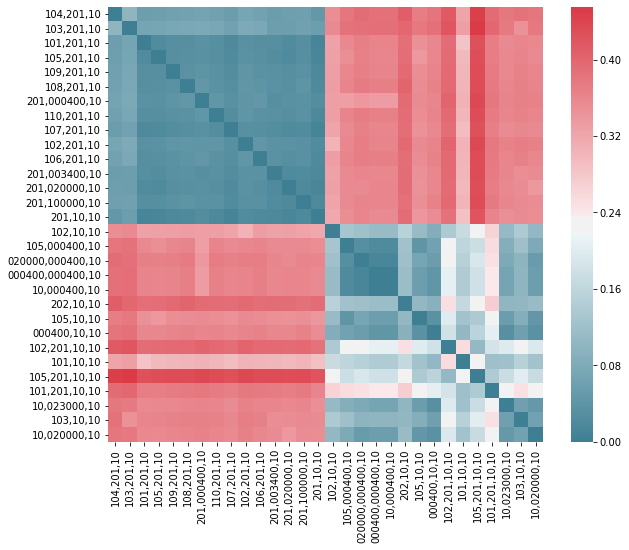

In [68]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [59]:
corr_matrix.to_csv('CreatedCSVS/corrmatrix_withids.csv')

### delete the correlated ids 
With the correlation matrix we decided which were the best items to keep in the data for the final dataframe that will be used for the cluster.

In [69]:
delids = [[201,10,10],
          [10,10,10],
          [201,10,10,10],
          [10,10,10,10],
          [10,10,'000400'],
          [10,'000400',10],
          [202,10,10],
          [10,10,10,10,10],
          [10,'020000',10],
          [10,100000,10],
          ['000400',10,10],
          [105,10,10]]
for i in range(len(delids)):
    delids[i]=list(map(str,delids[i]))

In [70]:
finalids = [x for x in sortedItems if x not in delids]

In [71]:
len(delids), len(finalids)

(12, 18)

In [73]:
finalRows = []
for i in range(len(finalids)):
    finalRows.append(",".join(finalids[i]))


## Create cluster dataframe
With the data that we need we can cluster the data. To do this is important to do a group by that gathers the data and checks which user repeats these important itemsets the most. 
Then to do the clustering we normalize the data and use 3 algorithms to ma

In [74]:
df_Cluster = df_final.T

In [78]:
df_Cluster['IDS'] = list(df.ids)

In [79]:
df_Cluster.head()

201,10,10  10,10,10  \
101,201,10,10,10,30,666                                     1         1   
102,201,10,10,020000,003000,10,666                          1         1   
103,201,10,100000,10,020000,10,666                          1         1   
104,201,10,10,10,10,10,666                                  1         1   
105,201,10,10,10,10,10,003400,100000,10,000400,...          1         1   

                                                    201,10,10,10  10,10,10,10  \
101,201,10,10,10,30,666                                        1            0   
102,201,10,10,020000,003000,10,666                             1            0   
103,201,10,100000,10,020000,10,666                             1            0   
104,201,10,10,10,10,10,666                                     1            1   
105,201,10,10,10,10,10,003400,100000,10,000400,...             1            1   

                                                    201,10,10,10,10  \
101,201,10,10,10,30,666                                           0   
102,201,10,10,020000,003000,10,666                                0   
103,201,10,100000,10,020000,10,666                                0   
104,201,10,10,10,10,10,666                                        1   
105,201,10,10,10,10,10,003400,100000,10,000400,...                1   

                                                    10,10,000400  \
101,201,10,10,10,30,666                                        0   
102,201,10,10,020000,003000,10,666                             0   
103,201,10,100000,10,020000,10,666                             0   
104,201,10,10,10,10,10,666                                     0   
105,201,10,10,10,10,10,003400,100000,10,000400,...             1   

                                                    10,000400,10  \
101,201,10,10,10,30,666                                        1   
102,201,10,10,020000,003000,10,666                             1   
103,201,10,100000,10,020000,10,666                             1   
104,201,10,10,10,10,10,666                                     1   
105,201,10,10,10,10,10,003400,100000,10,000400,...             1   

                                                    201,10,000400  \
101,201,10,10,10,30,666                                         0   
102,201,10,10,020000,003000,10,666                              0   
103,201,10,100000,10,020000,10,666                              0   
104,201,10,10,10,10,10,666                                      0   
105,201,10,10,10,10,10,003400,100000,10,000400,...              1   

                                                    10,10,000400,10  \
101,201,10,10,10,30,666                                           0   
102,201,10,10,020000,003000,10,666                                0   
103,201,10,100000,10,020000,10,666                                0   
104,201,10,10,10,10,10,666                                        1   
105,201,10,10,10,10,10,003400,100000,10,000400,...                1   

                                                    202,10,10  ...  \
101,201,10,10,10,30,666                                     1  ...   
102,201,10,10,020000,003000,10,666                          1  ...   
103,201,10,100000,10,020000,10,666                          1  ...   
104,201,10,10,10,10,10,666                                  1  ...   
105,201,10,10,10,10,10,003400,100000,10,000400,...          1  ...   

                                                    10,10,020000  \
101,201,10,10,10,30,666                                        0   
102,201,10,10,020000,003000,10,666                             1   
103,201,10,100000,10,020000,10,666                             1   
104,201,10,10,10,10,10,666                                     0   
105,201,10,10,10,10,10,003400,100000,10,000400,...             1   

                                                    000400,10,10  \
101,201,10,10,10,30,666                                        1   
102,201,10,10,020000,003000,10,666                           

In [28]:
#Only use this next line if there are rows with only zeros
#df_Cluster = df_Cluster[(df_Cluster.T != 0).any()]

In [80]:
df_Cluster = df_Cluster.groupby(['IDS']).sum()



min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df_Cluster.values)
df_Cluster.loc[:,:]=x_scaled

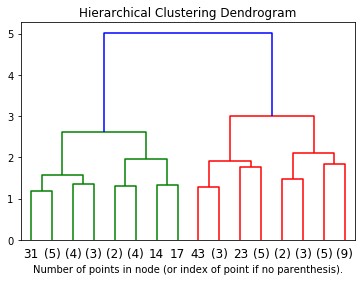

In [82]:
x_used = df_Cluster.loc[:,finalRows].values

inertias = []
K= range(2,10)
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(x_used)    
    inertias.append(kmeanModel.inertia_) 
    
hModel = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean').fit(x_used)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(hModel, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()



In [83]:
hModel.n_clusters_

50

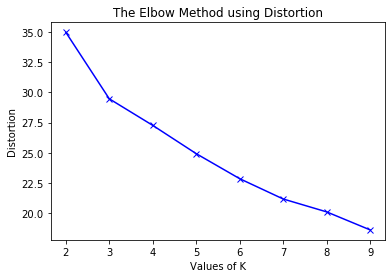

In [84]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [95]:
kmeanModel = KMeans(n_clusters=5).fit(x_used) 

In [96]:
hModel = AgglomerativeClustering(n_clusters=5, affinity='euclidean').fit(x_used)

In [97]:
dbModel = DBSCAN(eps=10, metric = 'cosine').fit(x_used)
np.unique(dbModel.labels_)

array([0])

In [98]:
df_Cluster['HierLabels'] = hModel.labels_
df_Cluster['KLabels'] = kmeanModel.labels_
df_Cluster['dbLabels'] = dbModel.labels_

In [99]:
df_Cluster.to_csv('CreatedCSVS/Cluster_Data.csv')